# Basics of BayesianSymbolic.jl

In [1]:
using InteractiveUtils, DrWatson, Comonicon
if isdefined(Main, :IJulia) && Main.IJulia.inited
    using Revise
else
    ENV["GKSwstype"] = 100 # suppress warnings during gif saving
end
versioninfo()
@quickactivate

Julia Version 1.6.0
Commit f9720dc2eb (2021-03-24 12:55 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU E5-2620 v3 @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, haswell)
Environment:
  JULIA_NUM_THREADS = 10


In [2]:
using Plots, Parameters, BenchmarkTools
theme(:bright; size=(300, 300))

In [3]:
using BayesianSymbolic

┌ Info: Precompiling BayesianSymbolic [d95aa7d0-ea3e-4103-b443-9ed45b862455]
└ @ Base loading.jl:1317
┌ Info: Skipping precompilation since __precompile__(false). Importing BayesianSymbolic [d95aa7d0-ea3e-4103-b443-9ed45b862455].
└ @ Base loading.jl:1025


## Define entities and initial states and ... run the simulation

Note that by default there are pairwise forces and a global vertical force that mimics the gravity in 2D.
There are means to change this behaviour, which are in other notebooks.

Note that you can also get individual entities or states back via `entity[i]` or `state0[i]`.

┌ Info: Number of states in the trajectory
│   length(trajectory) = 100
└ @ Main In[4]:29


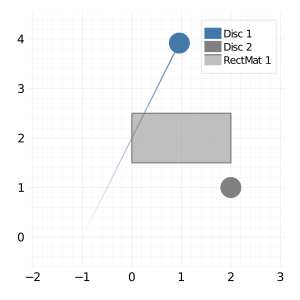

In [4]:
function simulate(entity, state0, dt, n_steps)
    trajectory = Vector{State}(undef, n_steps)
    for i in 1:n_steps
        if i == 1
            trajectory[i] = run(Leapfrog(dt), entity, state0)
        else
            trajectory[i] = run(Leapfrog(dt), entity, trajectory[i-1])
        end
    end
    return trajectory
end

entity_x = Entity(dynamic=true,  mass=1e0, magnetism=+1e+0, shape=Disc(2e-1))
entity_y = Entity(dynamic=false, mass=1e0, magnetism=-1e+1, shape=Disc(2e-1))
entity_z = Entity(dynamic=false, friction=+5e-1, shape=RectMat(2e0, 1e0))

entity = cat(entity_x, entity_y, entity_z)

state0_x = State(position=[-1e0, +0e0], velocity=[+1e0, +2e0])
state0_y = State(position=[+2e0, +1e0])
state0_z = State(position=[+1e0, +2e0])

state0 = cat(state0_x, state0_y, state0_z)

dt, n_steps = 2e-2, 100

trajectory = simulate(entity, state0, dt, n_steps)

@info "Number of states in the trajectory" length(trajectory)

plot(entity, [state0, trajectory...])

┌ Info: Saved animation to 
│   fn = /afs/inf.ed.ac.uk/user/s16/s1672897/projects/bayesian_symbolic_physics/notebooks/tmp.gif
└ @ Plots /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/packages/Plots/IjNHT/src/animation.jl:104


Plots.AnimatedGif("/afs/inf.ed.ac.uk/user/s16/s1672897/projects/bayesian_symbolic_physics/notebooks/tmp.gif")
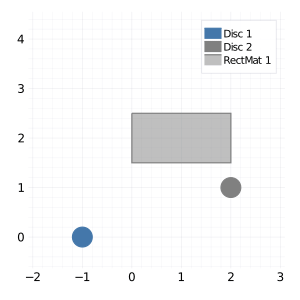

In [5]:
anim = @animate for i in 1:(n_steps+1)
    plot(entity, [state0, trajectory...], i)
end

gif(anim)

┌ Info: Saved animation to 
│   fn = /afs/inf.ed.ac.uk/user/s16/s1672897/projects/bayesian_symbolic_physics/notebooks/tmp.gif
└ @ Plots /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/packages/Plots/IjNHT/src/animation.jl:104


Plots.AnimatedGif("/afs/inf.ed.ac.uk/user/s16/s1672897/projects/bayesian_symbolic_physics/notebooks/tmp.gif")
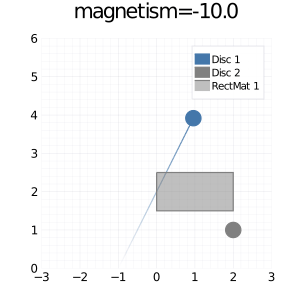

In [6]:
anim = @animate for magnetism in -10:5e-1:10
    entity′ = cat(entity_x, reconstruct(entity_y, magnetism=magnetism), entity_z)
    trajectory′ = simulate(entity′, state0, dt, n_steps)
    p = plot(entity′, [state0, trajectory′...])
    xlims!(-3, +3); ylims!(+0, +6)
    title!("magnetism=$magnetism")
    p
end

gif(anim; fps=5)

┌ Info: Saved animation to 
│   fn = /afs/inf.ed.ac.uk/user/s16/s1672897/projects/bayesian_symbolic_physics/notebooks/tmp.gif
└ @ Plots /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/packages/Plots/IjNHT/src/animation.jl:104


Plots.AnimatedGif("/afs/inf.ed.ac.uk/user/s16/s1672897/projects/bayesian_symbolic_physics/notebooks/tmp.gif")
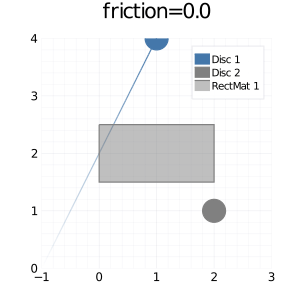

In [7]:
anim = @animate for friction in 0:2e-1:5
    entity′ = cat(entity_x, entity_y, reconstruct(entity_z, friction=friction))
    trajectory′ = simulate(entity′, state0, dt, n_steps)
    p = plot(entity′, [state0, trajectory′...])
    xlims!(-1, +3); ylims!(+0, +4)
    title!("friction=$friction")
    p
end

gif(anim; fps=5)

### Vectorization

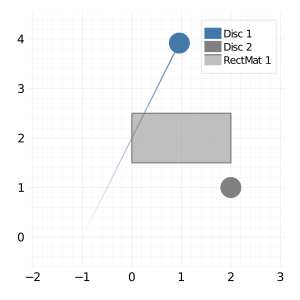

In [8]:
states = cat([state0, trajectory[1:end-1]...]...)
states = State(position=states.position, velocity=states.velocity)
states = run(Leapfrog(dt), entity, states)
trajectory_vec = [states[:,t] for t in 1:size(states, 3)]

plot(entity, [state0, trajectory_vec...])

### Performance difference

In [9]:
using BenchmarkTools

t_seq = @belapsed simulate(entity, state0, dt, n_steps)
t_vec = @belapsed run(Leapfrog(dt), entity, states)

@info "Comparison" t_seq t_vec

┌ Info: Comparison
│   t_seq = 0.002197621
│   t_vec = 0.000104482
└ @ Main In[9]:6
